## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N = 14
N_filled = N // 2
E_neg1 = 0
P_neg1 = np.exp(-1j * E_neg1)
t = -0.5
g = 0#1e-3
m = -0.8
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 4], [0.5, 4, 5], [0.5, 5, 6], [0.5, 6, 7], [0.5, 7, 8], [0.5, 8, 9], [0.5, 9, 10], [0.5, 10, 11], [0.5, 11, 12], [0.5, 12, 13], [0.5, 13, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 4, 3], [0.5, 5, 4], [0.5, 6, 5], [0.5, 7, 6], [0.5, 8, 7], [0.5, 9, 8], [0.5, 10, 9], [0.5, 11, 10], [0.5, 12, 11], [0.5, 13, 12], [0.5, 0, 13]]], ['+-', [[-0.8, 0, 0], [0.8, 1, 1], [-0.8, 2, 2], [0.8, 3, 3], [-0.8, 4, 4], [0.8, 5, 5], [-0.8, 6, 6], [0.8, 7, 7], [-0.8, 8, 8], [0.8, 9, 9], [-0.8, 10, 10], [0.8, 11, 11], [-0.8, 12, 12], [0.8, 13, 13]]], ['+-', [[0, 0, 0]]], ['+-+-', [[0, 0, 0, 0, 0]]], ['+-', [[0, 0, 0], [0, 1, 1]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1

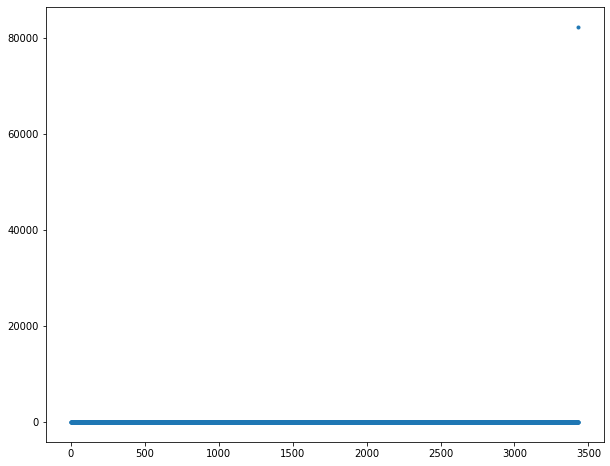

In [4]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.show()

In [5]:
# This is used later in real time dynamics, so keep a copy
H_init = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 4], [0.5, 4, 5], [0.5, 5, 6], [0.5, 6, 7], [0.5, 7, 8], [0.5, 8, 9], [0.5, 9, 10], [0.5, 10, 11], [0.5, 11, 12], [0.5, 12, 13], [0.5, 13, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 4, 3], [0.5, 5, 4], [0.5, 6, 5], [0.5, 7, 6], [0.5, 8, 7], [0.5, 9, 8], [0.5, 10, 9], [0.5, 11, 10], [0.5, 12, 11], [0.5, 13, 12], [0.5, 0, 13]]], ['+-', [[-0.8, 0, 0], [0.8, 1, 1], [-0.8, 2, 2], [0.8, 3, 3], [-0.8, 4, 4], [0.8, 5, 5], [-0.8, 6, 6], [0.8, 7, 7], [-0.8, 8, 8], [0.8, 9, 9], [-0.8, 10, 10], [0.8, 11, 11], [-0.8, 12, 12], [0.8, 13, 13]]], ['+-', [[0, 0, 0]]], ['+-+-', [[0, 0, 0, 0, 0]]], ['+-', [[0, 0, 0], [0, 1, 1]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1

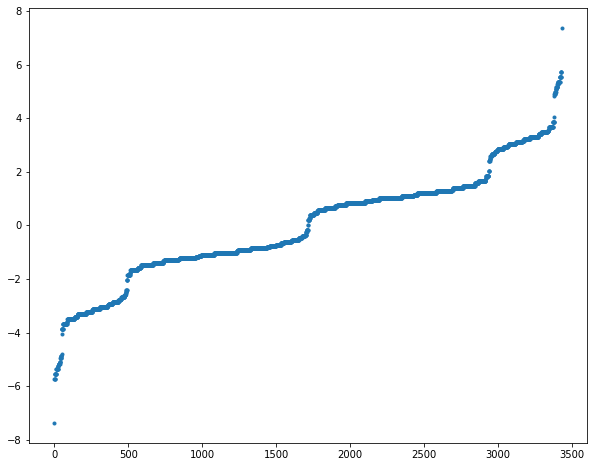

In [6]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
# E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
# for i in range(N):
#     E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
#     static_terms += [["z" * (i+1), [E_coupling]]]
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [7]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-7.37966983 -5.71892835 -5.71892835 ...  5.71892835  5.71892835
  7.37966983]
----------------------------------------------------------------------------------------------------
Spin eigenvalues:-----------------------------------------------------------------------------------
[    0.     0.     0. ...     0.     0. 82368.]
----------------------------------------------------------------------------------------------------
Maximum difference between eigenvalues: 82360.62033017304


## Real-time Dynamics

In [8]:
### Defining time-evolution hamiltonian
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
for i in range(N):
    static_terms += E_squared(i)

H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [9]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i=V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

In [10]:
T = 4#g ** (-1)
dt = T / 40

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
# file_Loschmidt = open(folder_save+'/Loschmidt_rate',"w")
# file_Loschmidt.close
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
#     file_Loschmidtfile = open(folder_save+'/Loschmidt_rate',"a")
    print(f"{times[i]}\t {Lt[i]}")#file_Loschmidtfile.write(f"{times[i]}\t {Lt[i]} \n")
    loschmidt += [Lt[i]]
#     file_Loschmidtfile.close()
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution

# T =  0.0
0.0	 -2.4513618734636656e-08
0.1	 0.0024066878331230764
0.2	 0.009681302520508833
0.30000000000000004	 0.02199281668663483
# T =  0.4
0.4	 0.03964258366942197
0.5	 0.06309820508278183
0.6000000000000001	 0.0930510364520047
0.7000000000000001	 0.1305106411449045
# T =  0.8
0.8	 0.17695680642039366
0.9	 0.23456589533828318
1.0	 0.3064192867660288
1.1	 0.3958163531723221
# T =  1.2000000000000002
1.2000000000000002	 0.5000545336234985
1.3	 0.5765072729498604
1.4000000000000001	 0.5395341560787077
1.5	 0.47550433302645484
# T =  1.6
1.6	 0.4119452930962556
1.7000000000000002	 0.344665435660329
1.8	 0.2802780940062006
1.9000000000000001	 0.22388798416257566
# T =  2.0
2.0	 0.17639247942856479
2.1	 0.13704525037151524
2.2	 0.10484170211224587
2.3000000000000003	 0.07892545271509235
# T =  2.4000000000000004
2.4000000000000004	 0.05865905500628129
2.5	 0.04360706928611914
2.6	 0.03350565090645891
2.7	 0.02823863093158083
# T =  2.8000000000000003
2.8000000000000003	 0.0278249877315

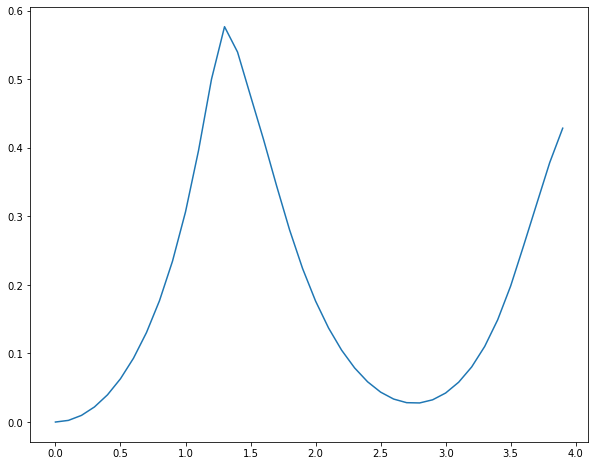

In [11]:
plt.plot(times, loschmidt)

## Joe OTOC Calculation Attempt

In [12]:
#psi_ground at t=0 correlated with psi_top at t=1

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j,dtype=dtype_cmplx)
# auxiliary array for memory efficiency

print(len(psi_i))
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
i = 1
expH.dot(psi,work_array=work_array,overwrite_v=True)

correlator = np.dot(psi_i, psi)
print("Correlator:",correlator)
# END of time evolution

3432
Correlator: (0.0005615607422957167+0.013695193105901983j)


## Drew Correlator calculation (Eqn. 2 of Niklas's paper)

In [13]:
def c_operator(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [c_operator(n) for n in range(N)]

In [14]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)

# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

for n in range(0, N, 2): #loop over all site pairings
    for i in range(len(times)): #loop over times (for annhilator location)
        # Even Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expmiH = expm_multiply_parallel((np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr().dot(np.transpose(P_Nhalf)))).dot(P_Nhalfminus1)),a=-1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H.tocsr(),a=1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

        correlators[n,i] = np.conj(tempLpsi).dot(tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
        
        # Odd Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

        correlators[n+1,i] = np.conj(tempLpsi).dot(tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
# correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
# END of time evolution

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [32]:
correlatorfft = []
for i in range(len(correlators[0, :])):
    fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
    correlatorfft.append(fftsum)
    
correlatorfft = np.array(correlatorfft)

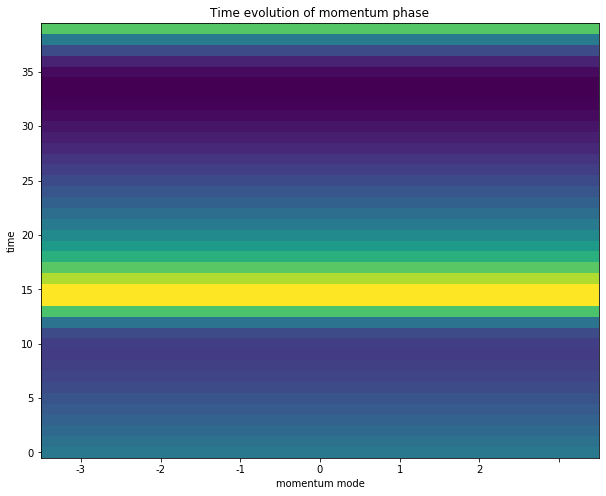

In [33]:
# plt.plot(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)))
plt.xlabel("momentum mode")
plt.ylabel("time")
plt.title("Time evolution of momentum phase")
no_labels = 7 # how many labels to see on axis x
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4) # labels you want to see
plt.xticks(x_positions, x_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')

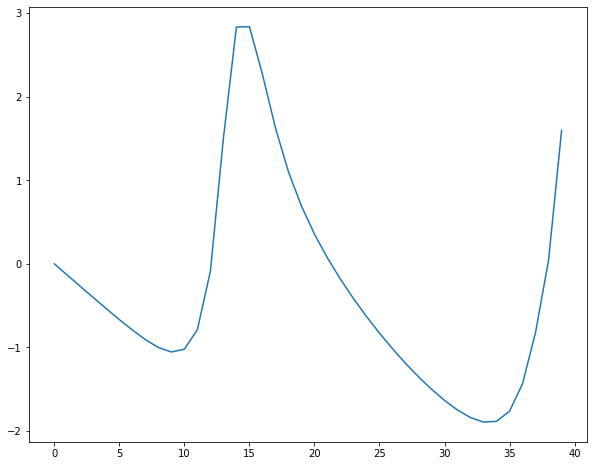

In [65]:
phases = np.arctan2(np.imag(correlatorfft), np.real(correlatorfft))
plt.plot(phases[:,3])
plt.show()

Text(0.5, 0, 'Time Slice')

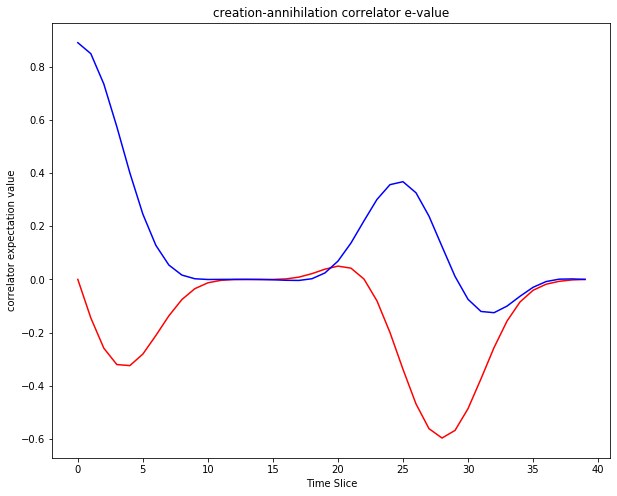

In [28]:
plt.plot(np.imag(correlators[0, :]),color='red',label="Imaginary Part")
plt.plot(np.real(correlators[0, :]),color='blue',label="Real Part")
plt.title("creation-annihilation correlator e-value")
plt.ylabel("correlator expectation value")
plt.xlabel("Time Slice")
# plt.figlegend()